# SKATER

## Spatial 'K'luster Analysis by Tree Edge Removal: Clustering Airbnb Spots in Chicago



Authors: [Xin Feng](https://github.com/xf37), [James Gaboardi](https://github.com/jGaboardi)

----------------------

The tutorial is broken out as follows:

1. An explanation of the SKATER algorithm
2. Supporting data: Airbnb Spots in Chicago
3. Understanding parameters
4. Regionalization
5. Exploring parameters

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

In [2]:
import geopandas
import libpysal
import matplotlib.pyplot as plt
import numpy
import pandas
import shapely
from sklearn.metrics import pairwise as skm
import spopt
import warnings

%matplotlib inline
%watermark -w
%watermark -iv

Watermark: 2.3.1

matplotlib: 3.6.2
numpy     : 1.23.5
geopandas : 0.12.2
spopt     : 0.4.1+200.g336f235.dirty
json      : 2.0.9
shapely   : 2.0.0
pandas    : 1.5.2
libpysal  : 4.7.0
sklearn   : 1.2.0




## 1. An explanation of the *SKATER* algorithm


*SKATER* ([Assunção et al. 2006](doi.org/10.1080/13658810600665111)) is a constrained spatial regionalization algorithm based on spanning tree pruning. The number of edges is pre-specified to be cut in a continuous tree to group spatial units into contiguous regions.  

The first step of *SKATER* is to create a connectivity graph that captures the neighbourhood relationship between the spatial objects. The cost of each edge in the graph is inversely proportional to the similarity between the regions it joins. The neighbourhood is structured by a [minimum spanning tree](https://en.wikipedia.org/wiki/Minimum_spanning_tree) (MST), which is a connected tree with no circuits. The next step is to partition the MST by successive removal of edges that link dissimilar regions. The final result is the division of the spatial objects into connected regions that have maximum internal homogeneity.

* **RM Assunção, MC Neves, G Câmara, and C da Costa Freitas**. *Efficient regionalization techniques for socio-economic geographical units using minimum spanning trees*. International Journal of Geographical Information Science, 20(7):797–811, 2006. doi: [10.1080/13658810600665111](doi.org/10.1080/13658810600665111).



See also [Dmitry Shkolnik's tutorial](https://www.dshkol.com/post/spatially-constrained-clustering-and-regionalization/) of the *SKATER* algorithm implemented in Roger Bivand's `R` package, [`spdep`](https://r-spatial.github.io/spdep/index.html).

-----------------

## 2. Supporting data: Airbnb Spots in Chicago

To illustrate `Skater` we utilize data on Airbnb spots in Chicago, which can be downloaded from [libpysal.examples](https://pysal.org/notebooks/lib/libpysal/Example_Datasets.html). The data is broken down into 77 communites in Chicago, Illinois from 2015, where a number of attributes are listed for each community.

In [3]:
libpysal.examples.load_example("AirBnB")

In [4]:
chicago = geopandas.read_file(libpysal.examples.get_path("airbnb_Chicago 2015.shp"))
chicago.shape

(77, 21)

In [5]:
chicago.loc[0]

community                                               DOUGLAS
shape_area                                        46004621.1581
shape_len                                         31027.0545098
AREAID                                                       35
response_r                                            98.771429
accept_r                                              94.514286
rev_rating                                            87.777778
price_pp                                              78.157895
room_type                                              1.789474
num_spots                                                    38
poverty                                                    29.6
crowded                                                     1.8
dependency                                                 30.7
without_hs                                                 14.3
unemployed                                                 18.2
income_pc                               

We can visualize the data by plotting the number of Airbnb spots in each community in the sample, using a quintile classification:

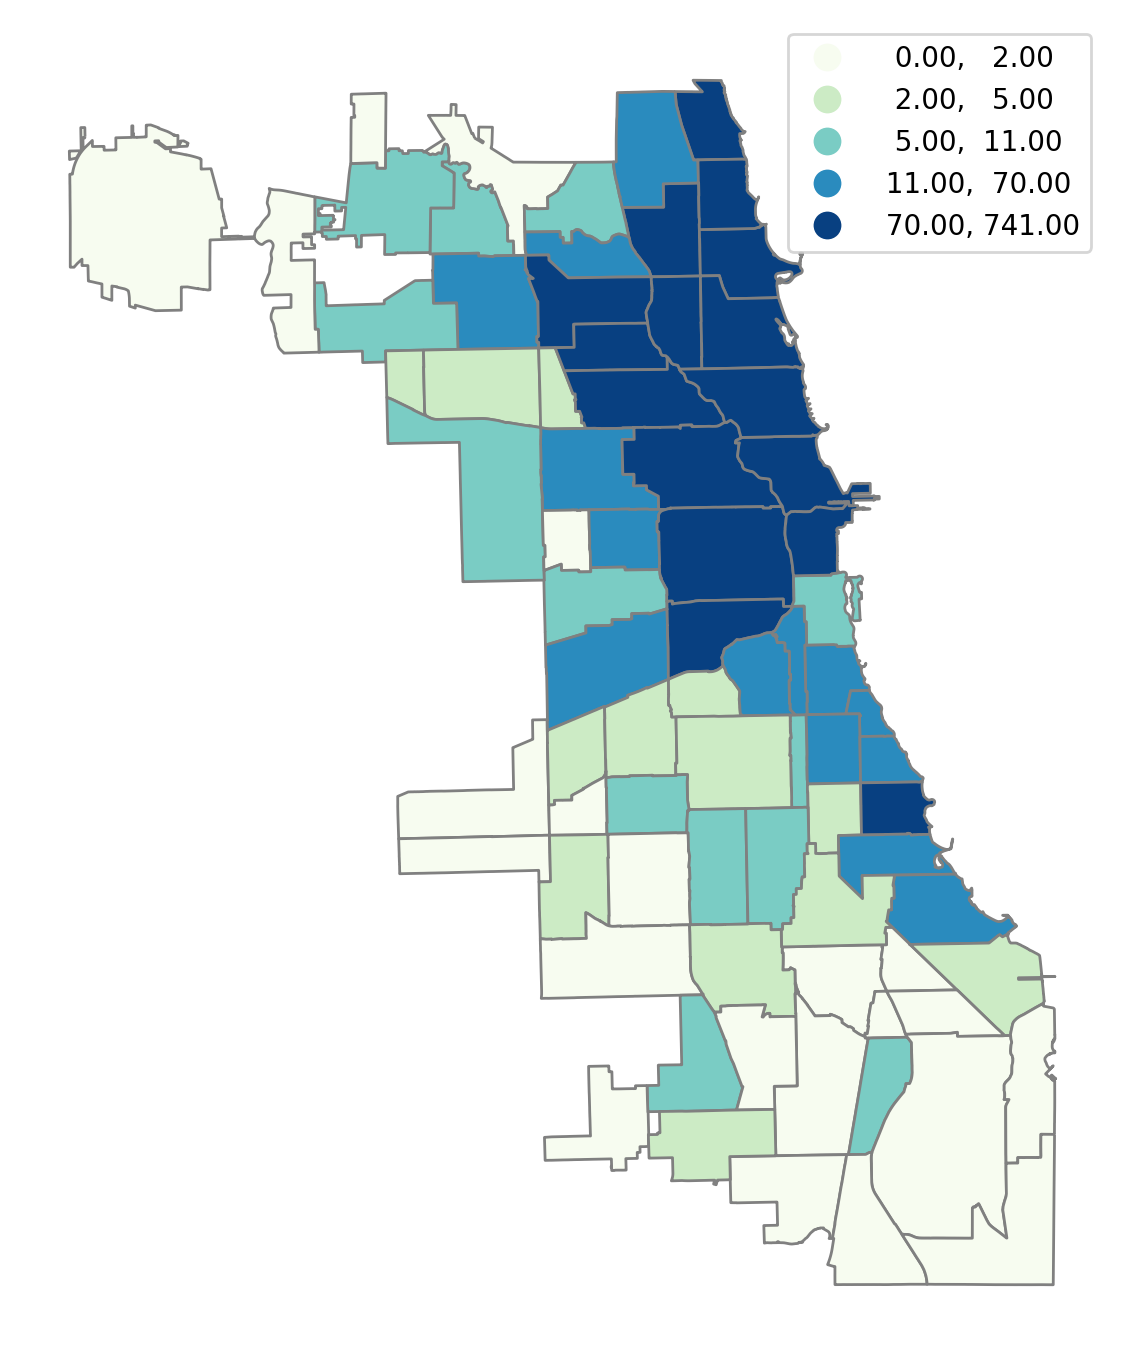

In [6]:
chicago.plot(
    figsize=(7, 14),
    column="num_spots",
    scheme="Quantiles",
    cmap="GnBu",
    edgecolor="grey",
    legend=True
).axis("off");

---------------------------------------

## 3. Understanding parameters

With Skater, we can cluster these 77 communities into 5 regions such that each region consists of at least 5 communities. The homogeneity of the number of Airbnb spots per community within the regions is maximized.

We first define the variable that will be used to measure regional homogeneity, which is the number of Airbnb spots in this case.

In [7]:
attrs_name = ["num_spots"]

Next, we specify a number of other parameters that will serve as input to the `skater` model, including the spatial weights (to describe the relationship between the spatial objects), the number of regions to include in the solution, the minimal threshold of spatial objects in each region, etc.

A [spatial weights object](https://pysal.org/libpysal/tutorial.html) describes the spatial connectivity of the spatial objects:

In [8]:
w = libpysal.weights.Queen.from_dataframe(chicago)

The number of contiguous regions that we would like to group spatial units into:

In [9]:
n_clusters = 5

The minimum number of spatial objects in each region：

In [10]:
floor = 5

 `trace` is a bool denoting whether to store intermediate labelings as the tree gets pruned.

In [11]:
trace = False

The `islands` keyword argument describes what is to be done with islands. It can be set to either `'ignore'`, which will treat each island as its own region when solving for `n_clusters` regions, or `'increase'`, which will consider each island as its own region and add to `n_clusters` regions.

In [12]:
islands = "increase"

We can also specify some keywords as input to the spanning forest algorithm, including:

* **dissimilarity**
  * A callable distance metric, with the default as [`sklearn.metrics.pairwise.manhattan_distances`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html).
* **affinity**
  * A callable affinity metric between 0 and 1, which is inverted to provide a dissimilarity metric. No metric is provided as a default (`None`). If `affinity` is desired, `dissimilarity` ***must*** explicitly be set to `None`. 
* **reduction**
  * The reduction applied over all clusters to provide the map score, with the default as [`numpy.sum()`](https://numpy.org/doc/stable/reference/generated/numpy.sum.html).
* **center**
  * The method for computing the center of each region in attribute space with the default as [`numpy.mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html).
* **verbose**
  * A flag for how much output to provide to the user in terms of print statements and progress bars. Set to `1` for minimal output and `2` for full output. The default is `False`, which provides no output.

See ``spopt.region.skater.SpanningForest`` for documentation.

In [13]:
spanning_forest_kwds = dict(
    dissimilarity=skm.manhattan_distances,
    affinity=None,
    reduction=numpy.sum,
    center=numpy.mean,
    verbose=2
)

## 4. Regionalization


The model can then be instantiated and solved:

In [14]:
model = spopt.region.Skater(
    chicago,
    w,
    attrs_name,
    n_clusters=n_clusters,
    floor=floor,
    trace=trace,
    islands=islands,
    spanning_forest_kwds=spanning_forest_kwds
)
model.solve()

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/76 [00:00<?, ?it/s]

making cut deletion(in_node=45, out_node=67, score=3445.5)...


finding cut...:   0%|          | 0/75 [00:00<?, ?it/s]

making cut deletion(in_node=15, out_node=13, score=2574.6813186813188)...


finding cut...:   0%|          | 0/74 [00:00<?, ?it/s]

making cut deletion(in_node=34, out_node=2, score=2146.556998556998)...


finding cut...:   0%|          | 0/73 [00:00<?, ?it/s]

making cut deletion(in_node=34, out_node=3, score=2025.520634920635)...


Region labels can then be added to the `GeoDataFrame` from the `model` object and used for plotting.

In [15]:
chicago["demo_regions"] = model.labels_

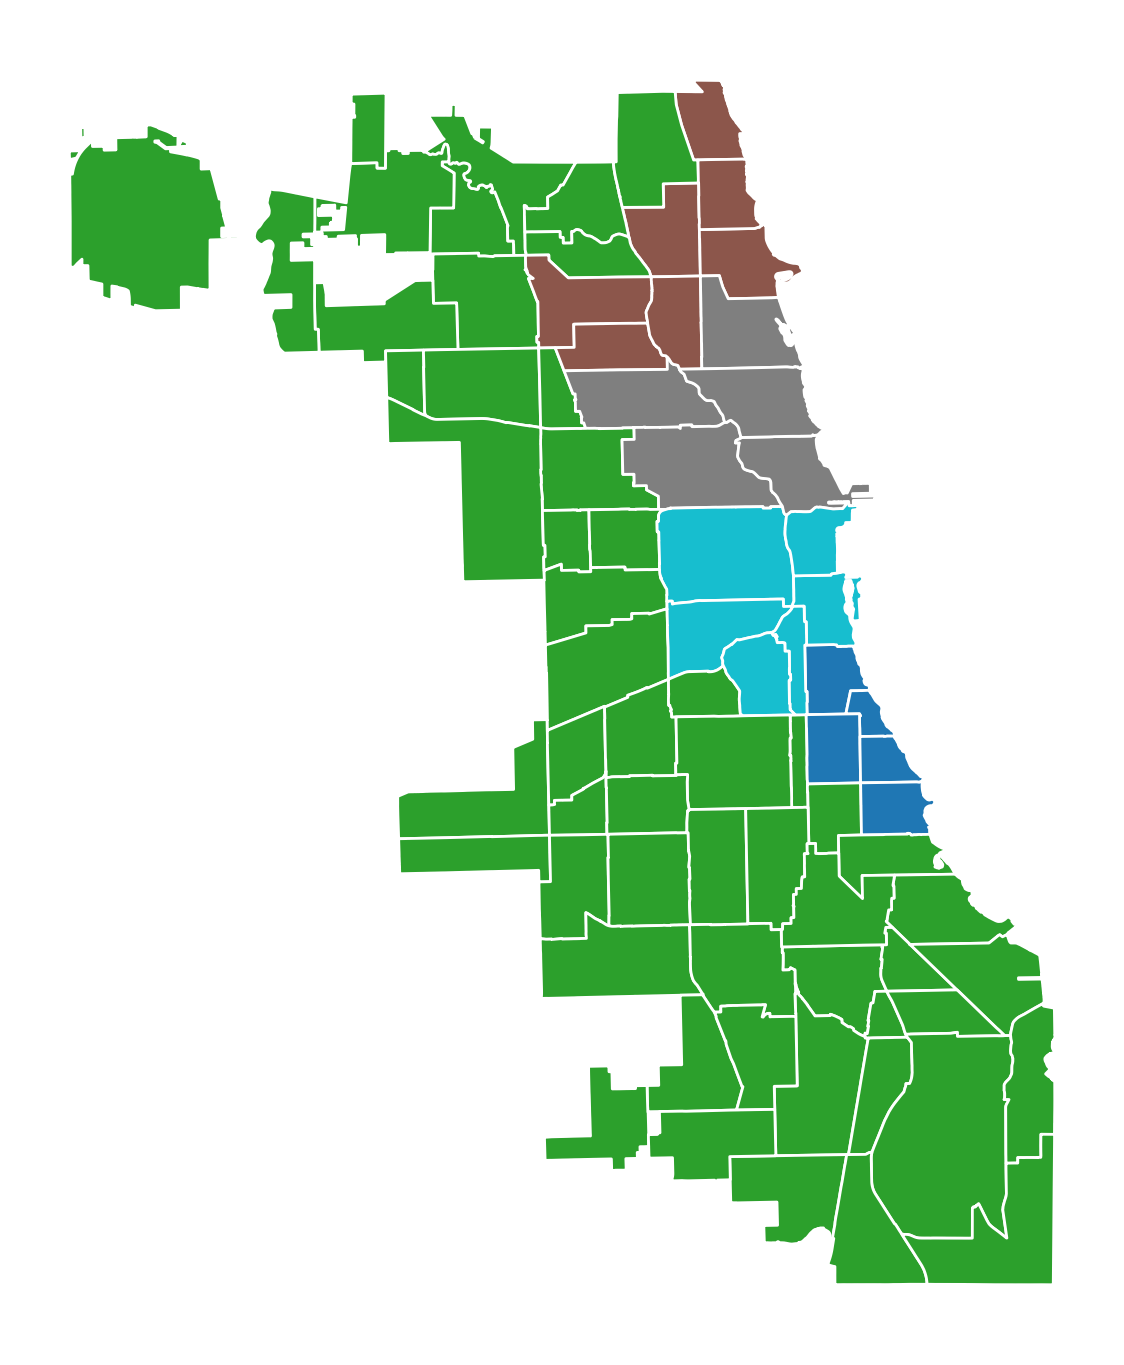

In [16]:
chicago.plot(
    figsize=(7, 14), column="demo_regions", categorical=True, edgecolor="w"
).axis("off");

The model solution results in five regions, two of which have five communities, one with six, one with seven, and one with fifty-four.

In [17]:
chicago["count"] = 1
chicago[["demo_regions", "count"]].groupby(by="demo_regions").count()

,count
demo_regions,
0,5
1,54
2,7
3,5
4,6


--------------------------------

## 5. Exploring parameters

There are myriad parameter combinations that can be passed in for regionalizing with `Skater`. Here we will explore two combinations of parameters.

* Increasing `n_clusters` while holding all other parameters constant
* Increasing `floor` while holding all other parameters constant
* Clustering on multiple variables

### Increasing `n_clusters`

Let's see how regionalization results differ when increasing `n_clusters` from 2 to 10 by increments of 2.

In [18]:
n_clusters_range = [2, 4, 6, 8, 10]
n_clusters_range

[2, 4, 6, 8, 10]

For each regionalization run we will hold the other parameters constant.

In [19]:
floor, trace, islands = 5, False, "increase"
spanning_forest_kwds = dict(
    dissimilarity=skm.manhattan_distances,
    affinity=None,
    reduction=numpy.sum,
    center=numpy.mean,
    verbose=False
)

Solve.

In [20]:
for ncluster in n_clusters_range:
    model = spopt.region.Skater(
        chicago,
        w,
        attrs_name,
        n_clusters=ncluster,
        floor=floor,
        trace=trace,
        islands=islands,
        spanning_forest_kwds=spanning_forest_kwds
    )
    model.solve()
    chicago[f"clusters_{ncluster}"] = model.labels_

Plot results.

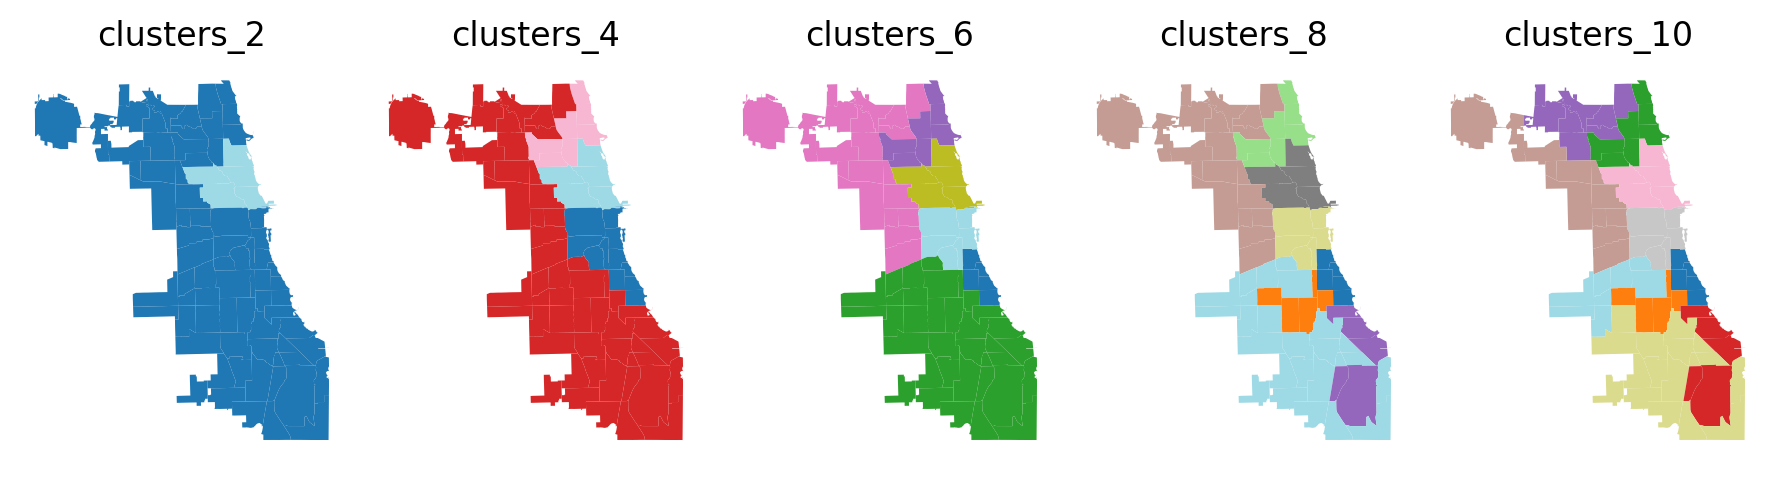

In [21]:
f, axarr = plt.subplots(1, len(n_clusters_range), figsize=(9, 7.5))
for ix, clust in enumerate(n_clusters_range):
    label = f"clusters_{clust}"
    chicago.plot(column=label, ax=axarr[ix], cmap="tab20")
    axarr[ix].set_title(label)
    axarr[ix].set_axis_off()
plt.subplots_adjust(wspace=1, hspace=0.5)
plt.tight_layout()

Above we can see that regions become more dispersed and boundaries become more consistent as the number of desired clusters increases. Also, we can investigate the count of communities and the number of AirBnB spots per region, as shown below.

In [22]:
attr1, attr2 = "count", "num_spots"
df = pandas.DataFrame(
    columns=pandas.MultiIndex.from_product(
        [[f"clusters_{i}" for i in n_clusters_range], [attr1, attr2]]
    ),
    index=range(10)
)
df.index.name = "region_id"
for i in n_clusters_range:
    col = f"clusters_{i}"
    df[col, attr1] = chicago[[col, attr1]].groupby(by=col).count()[attr1]
    df[col, attr2] = chicago[[col, attr2]].groupby(by=col).sum()[attr2]
df.fillna(0).astype(int).astype(str).replace("0", "-")

clusters_2           clusters_4           clusters_6            \
               count num_spots      count num_spots      count num_spots   
region_id                                                                  
0                 72      2321         11       963          5       236   
1                  5      2705         54       429         35       143   
2                  -         -          7       929          7       929   
3                  -         -          5      2705         19       286   
4                  -         -          -         -          5      2705   
5                  -         -          -         -          6       727   
6                  -         -          -         -          -         -   
7                  -         -          -         -          -         -   
8                  -         -          -         -          -         -   
9                  -         -          -         -          -         -   

          clusters_8           clusters_10            
               count num_spots       count num_spots  
region_id                                             
0                  5       236           5       236  
1                  5        38           5        38  
2                  7       929           7       929  
3                  5        58           5        58  
4                 19       286           8       147  
5                  5      2705          11       139  
6                  6       727           5      2705  
7                 25        47           6       727  
8                  -         -          17        27  
9                  -         -           8        20

### Increasing `floor`

Next we'll increase `floor` from 3 to 15 by increments of 3.

In [23]:
floor_range = [3, 6, 9, 12, 15]
floor_range

[3, 6, 9, 12, 15]

For each regionalization run we will hold the other parameters constant.

In [24]:
n_clusters, trace, islands = 3, True, "increase"
spanning_forest_kwds = dict(
    dissimilarity=None,
    affinity=skm.euclidean_distances,
    reduction=numpy.sum,
    center=numpy.std,
    verbose=False
)

Solve.

In [25]:
for floor in floor_range:
    model = spopt.region.Skater(
        chicago,
        w,
        attrs_name,
        n_clusters=n_clusters,
        floor=floor,
        trace=trace,
        islands=islands,
        spanning_forest_kwds=spanning_forest_kwds
    )
    with warnings.catch_warnings():
        # due to `affinity`
        warnings.filterwarnings(
            "ignore",
            category=RuntimeWarning,
            message="divide by zero encountered in log",
        )
        model.solve()
    chicago[f"floor_{floor}"] = model.labels_

Plot results.

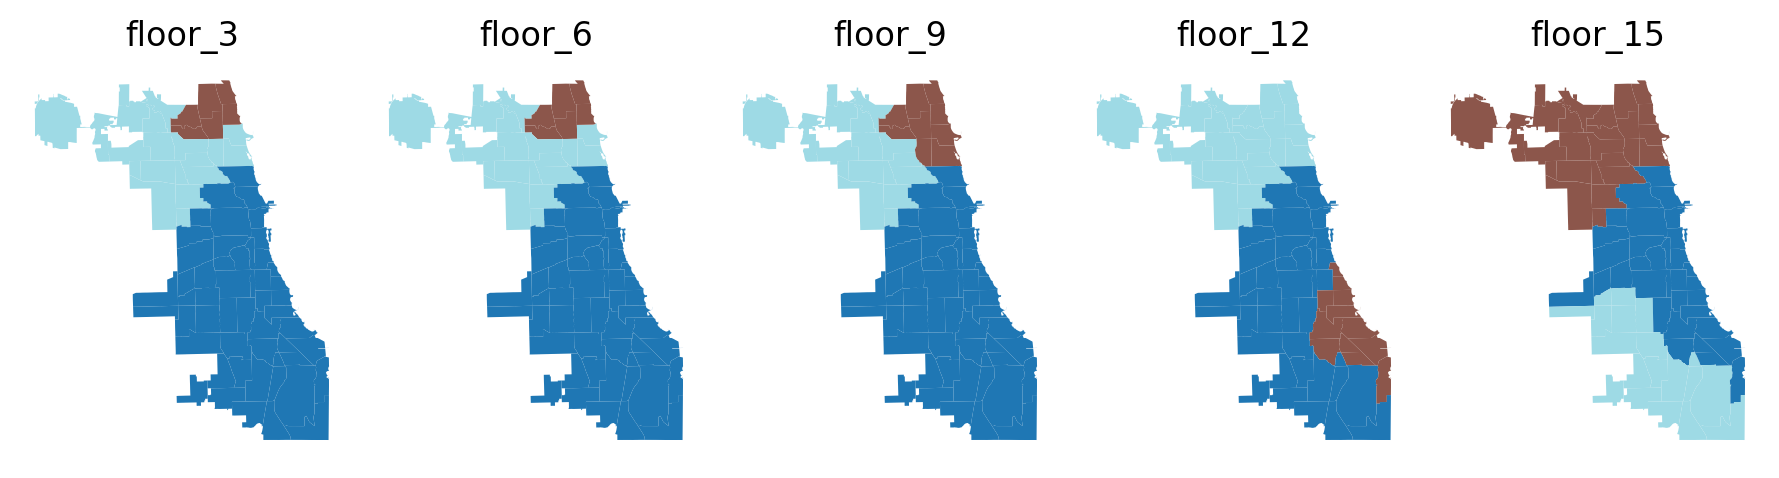

In [26]:
f, axarr = plt.subplots(1, len(floor_range), figsize=(9, 7.5))
for ix, floor in enumerate(floor_range):
    label = f"floor_{floor}"
    chicago.plot(column=label, ax=axarr[ix], cmap="tab20")
    axarr[ix].set_title(label)
    axarr[ix].set_axis_off()
plt.subplots_adjust(wspace=1, hspace=0.5)
plt.tight_layout()

Above we can see an interesting pattern. Boundaries are fixed when stipulating a minimum of 3 and 6 communities per region then the smallest region increases by 3 communities when stipulating `floor==9`. However, as the minimum number of communities is increased to 12 and 15 the location, shape, and rank of the 3 desired regions vary greatly. See the count of communities and the number of AirBnB spots per region below.

In [27]:
attr1, attr2 = "count", "num_spots"
df = pandas.DataFrame(
    columns=pandas.MultiIndex.from_product(
        [[f"floor_{i}" for i in floor_range], [attr1, attr2]]
    ),
    index=range(3)
)
df.index.name = "region_id"
for i in floor_range:
    col = f"floor_{i}"
    df[col, attr1] = chicago[[col, attr1]].groupby(by=col).count()[attr1]
    df[col, attr2] = chicago[[col, attr2]].groupby(by=col).sum()[attr2]
df

floor_3           floor_6           floor_9           floor_12  \
            count num_spots   count num_spots   count num_spots    count   
region_id                                                                  
0              52      2867      52      2867      52      2867       40   
1               6       504       6       504       9      1440       12   
2              19      1655      19      1655      16       719       25   

                    floor_15            
          num_spots    count num_spots  
region_id                               
0              2639       33      2814  
1               228       25      2159  
2              2159       19        53

### Clustering on more than one variable

First, let's isolate some of the variables in the dataset that are characterisitc of social vulnerability.

In [28]:
attrs_name = [
    "poverty",
    "crowded",
    "without_hs",
    "unemployed",
    "harship_in",
    "num_crimes",
    "num_theft"
]

Not all values are available in all communities for each variable, so we'll set those to 0.

In [29]:
for i in attrs_name:
    chicago[i] = chicago[i].fillna(0)

Now we'll see how regionalization results differ when increasing `n_clusters` from 3 to 7 by increments of 1 while considering the 7 social vulnerability variables.

In [30]:
n_clusters_range = [3, 4, 5, 6, 7]
n_clusters_range

[3, 4, 5, 6, 7]

For each regionalization run we will hold the other parameters constant.

In [31]:
floor, trace, islands = 8, True, "increase"
spanning_forest_kwds = dict(
    dissimilarity=skm.manhattan_distances,
    affinity=None,
    reduction=numpy.sum,
    center=numpy.mean,
    verbose=False
)

Solve.

In [32]:
for ncluster in n_clusters_range:
    model = spopt.region.Skater(
        chicago,
        w,
        attrs_name,
        n_clusters=ncluster,
        floor=floor,
        trace=trace,
        islands=islands,
        spanning_forest_kwds=spanning_forest_kwds
    )
    model.solve()
    chicago[f"clusters_{ncluster}"] = model.labels_

Plot results.

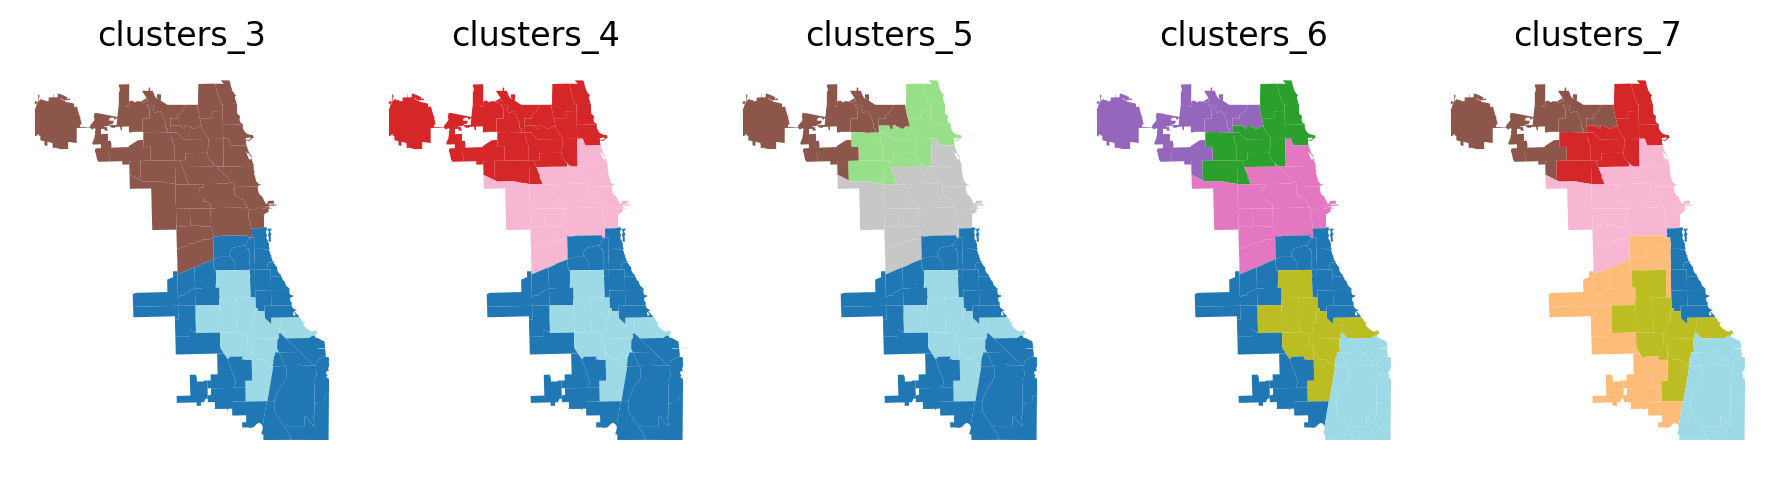

In [33]:
f, axarr = plt.subplots(1, len(n_clusters_range), figsize=(9, 7.5))
for ix, clust in enumerate(n_clusters_range):
    label = f"clusters_{clust}"
    chicago.plot(column=label, ax=axarr[ix], cmap="tab20")
    axarr[ix].set_title(label)
    axarr[ix].set_axis_off()
plt.subplots_adjust(wspace=1, hspace=0.5)
plt.tight_layout()

When considering multiple related variables certain cores regions are present in all solutions.

-----------------------------------